In [72]:
import numpy as np

In [73]:
from __future__ import annotations
from copy import deepcopy
import random


class FireFly:
    def __init__(self, N: int) -> None:
        """
        N: число городов (число вершин в графе)
        """
        self.N = N
        self.genotype = np.array([
            np.random.randint(0, N - i) for i in range(N)
        ])
    
    def __repr__(self) -> str:
        return f'{self.genotype}'
    
    def __len__(self) -> int:
        return self.N
    
    def __eq__(self, other: FireFly) -> bool:
        return np.all(self.genotype == other.genotype)
    
    def crossing(self, brighter_firefly: FireFly) -> None:
        """
        Оператор скрещивания (скрещивание будет модифицировать одну особь, которая имеет меньшую яркость)
        """
        divider = random.randint(1, self.N - 1)
        self.genotype[divider:] = brighter_firefly.genotype[divider:]
    
    # @staticmethod
    # def crossing(individual1: FireFly, individual2: FireFly) -> tuple[FireFly]:
    #     """
    #     Оператор скрещивания
    #     """
    #     divider = random.randint(1, len(individual1) - 1)
    #     child1, child2 = deepcopy(individual1), deepcopy(individual2)
    #     child1.genotype[divider:], child2.genotype[divider:] = individual2.genotype[divider:], individual1.genotype[divider:]
    #     return child1, child2
    
    def mutation(self) -> None:
        """
        [5, 4, 3, 2, 1, 0] - I
        ----------------------------------------
        [4, 0, 2, 1, 1, 0] - особь p

        [1, 4, 1, 1, 0, 0] - верхняя граница, сколько можно прибавить
        [4, 0, 2, 1, 1, 0] - верхняя граница, сколько можно отнять
        ----------------------------------------
        [5, 4, 3, 2, 1, 0] - особь p

        [0, 0, 0, 0, 0, 0] - верхняя граница, сколько можно прибавить
        [5, 4, 3, 2, 1, 0] - верхняя граница, сколько можно отнять
        ----------------------------------------
        [0, 0, 0, 0, 0, 0] - особь p

        [5, 4, 3, 2, 1, 0] - верхняя граница, сколько можно прибавить
        [0, 0, 0, 0, 0, 0] - верхняя граница, сколько можно отнять
        ----------------------------------------
        [-p, I - p] - границы
        """
        k = random.randint(0, self.N - 1)
        left_bound = -self.genotype[k]
        right_bound = self.N - 1 - k - self.genotype[k]
        self.genotype[k] += random.randint(left_bound, right_bound)

    def get_route(self) -> list[int]:
        L = list(range(self.N))
        return [L.pop(gene) for gene in self.genotype]

In [74]:
def get_graph(path: str) -> np.ndarray:
    with open(path, 'r') as f:
        N = int(f.readline())
        matrix = np.zeros((N, N))
        for row in f.readlines():
            v1, v2, value = row.strip().split()
            matrix[int(v1) - 1, int(v2) - 1] = value
            matrix[int(v2) - 1, int(v1) - 1] = value
    return N, matrix


In [104]:
from typing import Iterable
import random


class Environment:
    def __init__(self, N: int, adjacency_matrix: np.ndarray, gamma: float = 0.9) -> None:
        """
        adjacency_matrix: матрица смежности (определяет длину пути из городов)
        gamma: уровень значимости привлекательности света для особей (
            если gamma -> 0, то светлячки со схожей яркостью не будут обращать друг на друга внимание, 
            если gamma -> 1, то светлячки со схожей яркостью будут всегда обращать друг на друга внимание
        )
        """
        self.N = N
        self.adjacency_matrix = adjacency_matrix
        self.gamma = gamma
    
    def __fitness(self, individual: FireFly) -> float:
        route = individual.get_route()
        return self.adjacency_matrix[route[-1], route[0]] + sum([
            self.adjacency_matrix[route[i], route[i + 1]] for i in range(len(route) - 1)
        ])
    
    def __init_population(self, population_size: int) -> Iterable[FireFly]:
        return [FireFly(self.N) for _ in range(population_size)]

    def __crossing_step(self, population: Iterable[FireFly], population_size: int, mutation_probability: float) -> None:
        for i in range(population_size):
            for j in range(population_size):
                if i < j:
                    p1: FireFly = population[i]
                    p2: FireFly = population[j]
                    p1_fitness = self.__fitness(p1)
                    p2_fitness = self.__fitness(p2)
                    pairs = [
                        (i, p1, p1_fitness), (j, p2, p2_fitness)
                    ]
                    min_fitness_firefly = min(pairs, key=lambda pair: pair[-1])
                    max_fitness_firefly = max(pairs, key=lambda pair: pair[-1])
                    if min_fitness_firefly[-1] / max_fitness_firefly[-1] < self.gamma:
                        population[max_fitness_firefly[0]].crossing(min_fitness_firefly[1])
                    if random.random() < mutation_probability:
                        population[min_fitness_firefly[0]].mutation()
                        
    def __find_best_individual(self, population: Iterable[FireFly]) -> tuple[float, list[int]]:
        sorted_population = sorted(
            population, 
            key=lambda individual: self.__fitness(individual)
        )
        best_individual = sorted_population[0]
        return (
            self.__fitness(best_individual), best_individual.get_route()
        )
        

    def get_answer(self, population_size: int, mutation_probability: float = 0.1, k_max: int = 200, plot: bool = True) -> tuple[
        float, list[int], list[tuple[float, list[int]]]
    ]:
        """
        population_size: размер популяции светлячков
        mutation_probability: вероятность мутации лучшей особи
        k_max: ограничение по числу итераций алгоритма
        """
        population = self.__init_population(population_size)

        best_fitness, best_route = self.__find_best_individual(population)

        best_list: list[tuple[float, list[int]]] = [(best_fitness, best_route)]

        for _ in range(k_max):
            self.__crossing_step(population, population_size, mutation_probability)
            population_best_fitness, population_best_route = self.__find_best_individual(population)
            best_list.append((population_best_fitness, population_best_route))
            if population_best_fitness < best_fitness:
                best_fitness = population_best_fitness
                best_route = population_best_route
            
        return best_fitness, best_route, best_list

In [105]:
N, adjacency_matrix = get_graph('data.txt')

In [112]:
env = Environment(N, adjacency_matrix, gamma=0.8)

In [115]:
fitness, route, history = env.get_answer(population_size=150, k_max=40)

In [116]:
fitness

91.0

In [132]:
a = map(lambda x: x[0], history)

In [133]:
b = list(a)

In [120]:
import matplotlib.pyplot as plt

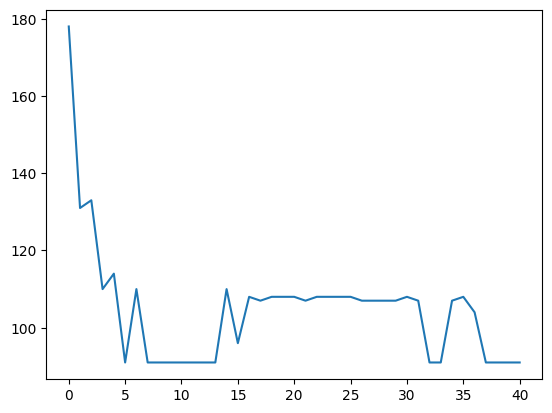

In [135]:
plt.plot(b)

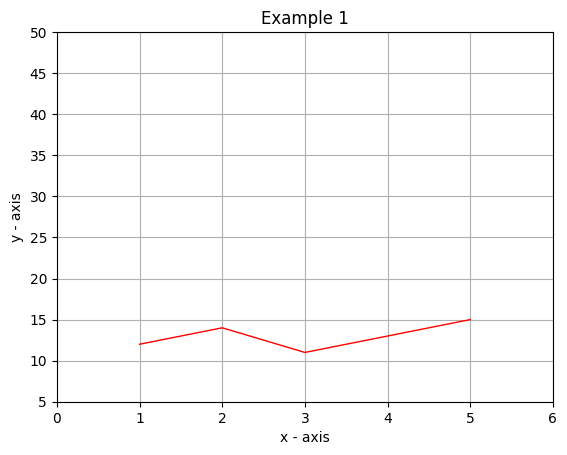

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [139]:
import matplotlib.pyplot as plt
import time
vec1=[1, 2, 3, 4, 5]
vec2py=[10, 12, 9, 11, 13]
plt.show()
axes = plt.gca()
axes.set_xlim(0, 6)
axes.set_ylim(5, 50)
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Example 1')
plt.grid()
line,= axes.plot(vec1,vec2py,color='red',lw=1)
for x in range(0,10):
    vec2py = [x + 2 for x in vec2py]
    line.set_ydata(vec2py)
    plt.draw()
    plt.pause(1e-17)
    time.sleep(0.5)
plt.show()